In [1]:
%cd /Volumes/Samsung_T5/ProtPredict/scripts

/Volumes/Samsung_T5/ProtPredict/scripts


## Load dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import cross_validate, KFold
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from other import create_features, Bayes_CV, create_cmap, extract_top_features,return_protein_dataset, extract_shap_return_absmeans, extract_xgb_feature_values

## Define initial parameters
Define initial parameters, such as number of workers, cross-validation setup and which protein to use for model optimization.

In [3]:
n_parallel = 60 #If parallel, define n workers

# define the K in the cross-validation strategies
cvcount_inner = 5 #K-fold for optimization
cvcount_outer = 5 #K-fold for evaluation

opt_protein = 'A5Z2X5' #protein to optimize the models on

## Load the data-sets
Load the needed data-sets. Data-sets from Messner et al. (https://www.biorxiv.org/content/10.1101/2022.05.17.492318v1) and Mülleder et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5055083/)

Data-sets need to be downloaded separately.

The "function create_features" will merge the input data-set (from Messner et al.) with the relational features generated in Aleph.

In [4]:
# load the proteomics dataset from Messner et al. (2022)
proteomic_dataset = pd.read_csv('../data/proteomics_messner.csv')
proteomic_dataset = proteomic_dataset.groupby('Unnamed: 0').mean() #Average potential duplicate rows

# load the functional metabolomics dataset from Mulleder et al. (2016)
aaDataset = pd.read_excel('../data/functional_metabolomics_mulleder.xls',sheet_name = 'intracellular_concentration_mM')
aaDataset.index = aaDataset['ORF']
aaDataset = aaDataset.iloc[:,2:21] #limit to the measured amino acid concentrations

# Merge the two on the ORF of the deletion
unified_dataset = pd.merge(proteomic_dataset, aaDataset, left_index=True, right_index=True)

# paths to relational features, note that the features derived from Mulleder et al. has been removed prior to generation
path_features = '../intermediateData/generated_features/proteomics_noAA_features.txt' #ordered features
path_labels = '../intermediateData/generated_features/proteomics_noAA.txt' #ordered positive examples

# Reformat and merge the unified dataset with relational features
dataset = create_features(path_features, path_labels, unified_dataset)

## Model optimization

Optimize/tune hyperparameters for XGBoost using bayesian optimization. In the study, the model is being tuned on the first example in the data-set (Uniprot: A5Z2X5, Common: MIN8, ORF: YPR010C-A)

In [ ]:
# Define the dictionary for the parameter-space used in model optimization
params={'gamma': (0.0,1.0),
        'max_depth': (2, 12),
        'subsample': (0.4, 1.0),
        'learning_rate':(0.005,0.3,'log-uniform'),
        'n_estimators':(10,1000),
        'colsample_bytree':(0.4, 1.0),
        'reg_lambda':(0.0,1.0),
        'reg_alpha':(0.0,0.5)}

# Function to define X and Y (we optimize on the first example in the dataset, A5Z2X5)
X, y, nancount = return_protein_dataset(dataset, 'A5Z2X5')

# define the bayesian optimization process. This will take some time!
best_params = Bayes_CV(params, X, y, cvcount_inner, n_parallel, 0)

## Train the models
Train the models for all of the separate proteins using XGBoost and then evaluate with 5-fold CV and save them for later use. Training and evaluating all of the protein models will take some time.

In [ ]:
#predefine scoring frame
scores = pd.DataFrame(columns = ['Protein','MissingY','R-squared','RMSE'])

for Protein in dataset.columns[:2292]:
    
    X, y, nancount = return_protein_dataset(dataset, Protein)

    # define regressor and evaluate model
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    outer_cv = KFold(n_splits=cvcount_outer, shuffle=True, random_state=0)
    score_all = cross_validate(regressor, X, np.ravel(y), cv=outer_cv, scoring = ('r2', 'neg_root_mean_squared_error'))
    score = score_all['test_r2']
    rmse = score_all['test_neg_root_mean_squared_error']

    # save scores
    temp_df = pd.DataFrame([[Protein, nancount,score[0],rmse[0]], [Protein, nancount,score[1],rmse[1]], [Protein, nancount,score[2],rmse[2]], 
            [Protein, nancount,score[3],rmse[3]], [Protein, nancount,score[4],rmse[4]]], columns=['Protein', 'MissingY', 'R-squared', 'RMSE'])
    scores = scores.append(temp_df)
    scores.to_csv('../results/evaluation/ILP/protfromAAILP_results.csv')


## Extract SHAP-values
Extract SHAP-values to be used for later analysis.

In [ ]:
shapmeans_proteins = pd.DataFrame(index = dataset.columns[2292:]) #predefine df for feature shap-values
for Protein in dataset.columns[:2292]:
    
    X, y, nancount = return_protein_dataset(dataset, Protein)
    
    # train regressor
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    regressor.fit(X,y)
    
    # extract shap-values (in the form of abs(average)) for all proteins in the dataset
    shapmeans_proteins = extract_shap_return_absmeans(regressor, X, Protein, shapmeans_proteins)
    shapmeans_proteins.to_csv('../intermediateData/feature_values/ILP/Proteins_AAILP_SHAP_means.tsv', sep = '\t')
    
    # extract all XGB-feature values (gain, total gain, ...) and save protein result each separately
    xgb_feature_values = extract_xgb_feature_values(regressor)
    xgb_feature_values.to_csv('../intermediateData/feature_values/AAILP/'+Protein+'_AAILP_XGB.tsv', sep = '\t')

## Visualize performance metrics
Visualize average cross-validation performance (in R2) across the space of available proteins in the data-set for each of the different feature-sets.

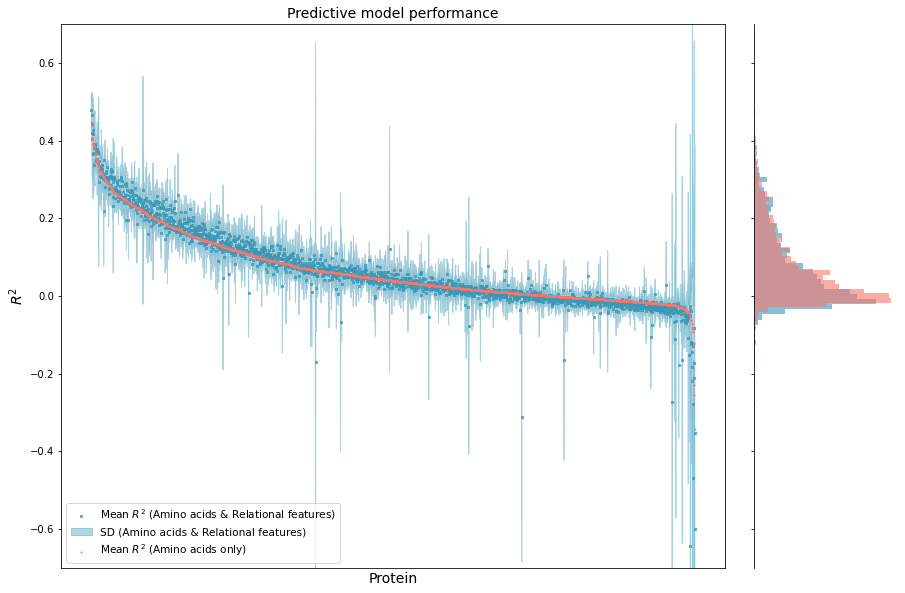

In [7]:
#Figure 4 should represent the difference in performance between featuresets (AA only vs ILP & AA)

# first, read performance for AA
data_AA = pd.read_csv('../results/evaluation/AA/AA_20230314.csv', index_col = 0)
data_AA_mean = data_AA.groupby(by='Protein').mean() #probably not needed
data_AA_mean = data_AA_mean.sort_values(by = 'R-squared', ascending = False)
data_AA_SD = pd.DataFrame(data_AA.groupby(by='Protein').std()['R-squared'])
data_AA_SD.columns = ['SD']

# first, read performance for AA+ILP
data_AAILP = pd.read_csv('../results/evaluation/AAILP/AAILP_20230311.csv', index_col = 0)
data_AAILP_mean = data_AAILP.groupby(by='Protein').mean() #probably not needed
data_AAILP_mean = data_AAILP_mean.sort_values(by = 'R-squared', ascending = False)
data_AAILP_SD = pd.DataFrame(data_AAILP.groupby(by='Protein').std()['R-squared'])
data_AAILP_SD.columns = ['SD']

# add in SD
data_AA_mean = pd.merge(data_AA_mean, data_AA_SD, left_index = True, right_index = True, how = 'left')
data_AAILP_mean = pd.merge(data_AAILP_mean, data_AAILP_SD, left_index = True, right_index = True, how = 'left')

# merge the two evaluation-sets for joint plotting
data = pd.merge(data_AA_mean, data_AAILP_mean, left_index = True, right_index = True, how = 'inner')

# Figure plotting
fig = plt.figure(figsize = (15,10))
gs = GridSpec(4,5)

ax_joint = fig.add_subplot(gs[0:4,0:4])
ax_marg_y = fig.add_subplot(gs[0:4,4])
ax_joint.scatter(data.index,data['R-squared_y'], alpha = 0.7, marker = 's', s = 7, label='ILP', color = '#3B97B6')
ax_joint.fill_between(data.index, data['R-squared_y'] - data['SD_y'], data['R-squared_y'] + data['SD_y'], color='#3B97B6', alpha=0.4, label = 'ILP_SD')
ax_joint.scatter(data.index,data['R-squared_x'], alpha = 1, marker = 'o',label='Amino acids', color = '#F8766D', s = 1)

ax_marg_y.hist(data['R-squared_y'],orientation="horizontal", bins = 100, alpha = 0.6, density = True, color = '#3B97B6')
ax_marg_y.hist(data['R-squared_x'],orientation="horizontal", bins = 100, alpha = 0.6, density = True, color = '#F8766D')

ax_marg_y.set_ylim([-0.7,0.7])
ax_joint.set_ylim([-0.7,0.7])

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Protein', fontsize = 14)
ax_joint.set_ylabel('$R^2$', fontsize = 14)

ax_marg_y.spines['top'].set_visible(False)
ax_marg_y.spines['right'].set_visible(False)
ax_marg_y.spines['bottom'].set_visible(False)

ax_joint.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_marg_y.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_joint.legend(['Mean $R^2$ (Amino acids & Relational features)','SD (Amino acids & Relational features)', 'Mean $R^2$ (Amino acids only)'], 
                loc = 'lower left', fontsize = 10.5)

ax_joint.set_title('Predictive model performance', fontsize = 14)
plt.show()


## Visualize amino acid dependencies in protein abundance predictions

Feature importances (SHAP) for the top 19 predictors (amino acids) scaled across proteins. 

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


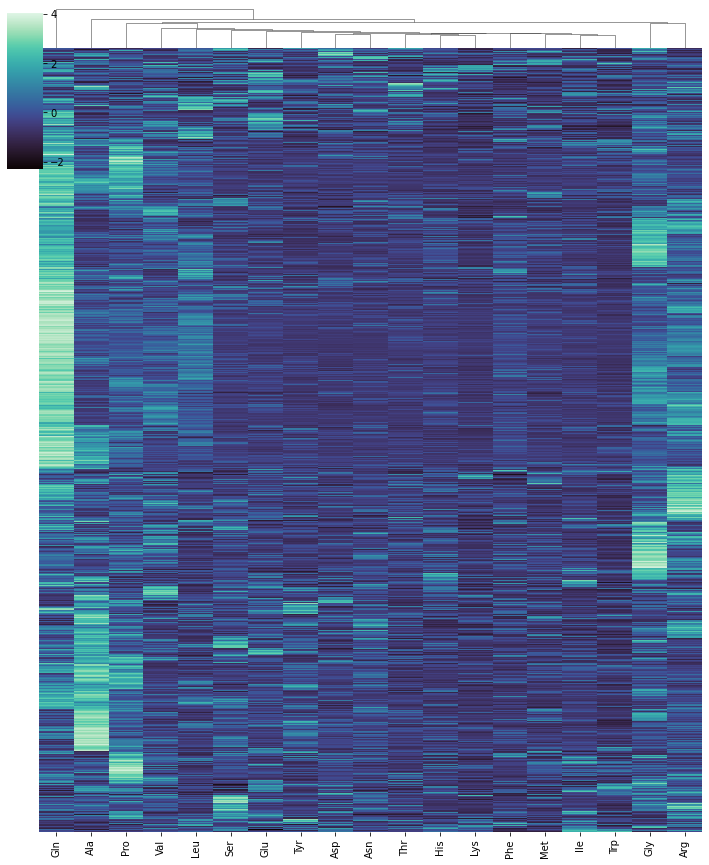

In [8]:
data_AAILP = pd.read_csv('../results/evaluation/AAILP/AAILP_20230311.csv', index_col = 0)
data_AAILP_mean = data_AAILP.groupby(by='Protein').mean() 
data_AAILP_mean = data_AAILP_mean.sort_values(by = 'R-squared', ascending = False)

feature_shap = pd.read_csv('../results/feature_values/AAILP/Proteins_AAILP_SHAP_means_20230311.tsv', sep = '\t', index_col = 0)
feature_shap = feature_shap.iloc[:,np.where(feature_shap.columns.isin(list(data_AAILP_mean[data_AAILP_mean['R-squared'] > 0].index)) == True)[0]] #only pick those with r2 over 0
feature_shap = feature_shap.rename(index={'alanine': 'Ala', 'arginine' : 'Arg', 'asparagine' : 'Asn', 'aspartate' : 'Asp',
                                          'glutamate' : 'Glu', 'glutamine' : 'Gln', 'glycine' : 'Gly', 'histidine' : 'His', 'isoleucine' : 'Ile',
                                          'leucine' : 'Leu', 'lysine' : 'Lys', 'methionine' : 'Met', 'phenylalanine' : 'Phe','proline' : 'Pro', 'serine' : 'Ser',
                                          'threonine' : 'Thr', 'tryptophan' : 'Trp', 'tyrosine' : 'Tyr', 'valine' : 'Val'})

# Figure 5, Heatmap
cg = sns.clustermap(data = feature_shap.iloc[:19,:].transpose(), figsize=(10,12), cmap = 'mako', z_score = 0, 
                    dendrogram_ratio = 0.05, row_cluster = True, xticklabels = True, yticklabels = False)
cg.ax_col_dendrogram.set_visible(True)
cg.ax_row_dendrogram.set_visible(False)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
sns.set_context('paper', font_scale=1.5)
plt.show()

## Per protein SHAP visualization

Train and extract SHAP-values for two different proteins using different feature-sets. In case of Protein 2, only the ILP derived features will be used. For protein 1, the combined data-set (AA+ILP) will be used for prediction.

In [27]:
# choose two proteins to visualize
Protein_1 = 'P00815' #onlyILP
Protein_2 = 'P07342' #AA+ILP

In [28]:
# Load data-sets

# paths to relational features, note that the features derived from Mulleder et al. has been removed prior to generation
path_features = '../intermediateData/generated_features/proteomics_noAA_features.txt' #ordered features
path_labels = '../intermediateData/generated_features/proteomics_noAA.txt' #ordered positive examples

# Reformat and merge the unified dataset with relational features
dataset = create_features(path_features, path_labels, unified_dataset)
X_P1, y_P1, nancount = return_protein_dataset(dataset, Protein_1)

# paths to relational features, note that the features derived from Mulleder et al. has been removed prior to generation
path_features = '../intermediateData/generated_features/proteomics_features.txt' #ordered features
path_labels = '../intermediateData/generated_features/proteomics.txt' #ordered positive examples

# Reformat and merge the unified dataset with relational features
dataset = create_features(path_features, path_labels, proteomic_dataset)
X_P2, y_P2, nancount = return_protein_dataset(dataset, Protein_2)



Removing perfectly correlated features...
Removing perfectly correlated features...


In [ ]:
# these were derived in previous steps (best parameters from the bayesian optimization)
best_params_P1 = pd.read_pickle('../intermediateData/parameters/GCV3_AAILP_20230311.pickle')
best_params_P2 = pd.read_pickle('../intermediateData/parameters/GCV3_protILP_20230309.pickle')

# Protein 1
regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params_P1)
regressor.fit(X_P1,y_P1)
explainer = shap.Explainer(regressor, X_P1)
shap_values = explainer(X_P1)
# save as pickle
with open('../results/feature_values/Detailed/'+Protein_1+'_SHAP.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Protein 2
regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params_P2)
regressor.fit(X_P2,y_P2)
explainer = shap.Explainer(regressor, X_P2)
shap_values = explainer(X_P2)
#save as pickle
with open('../results/feature_values/Detailed/'+Protein_2+'_SHAP.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)


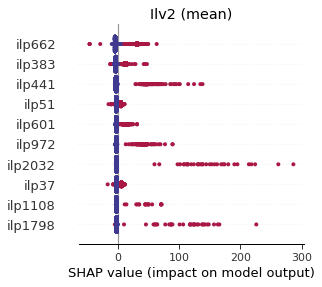

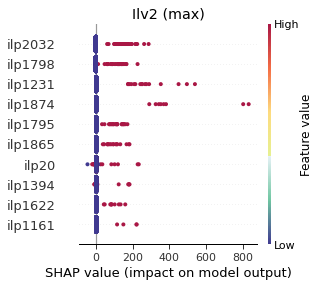

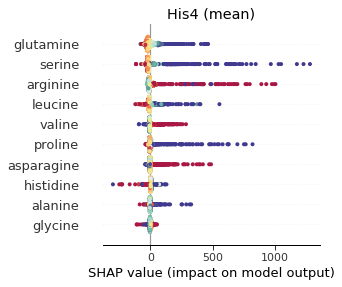

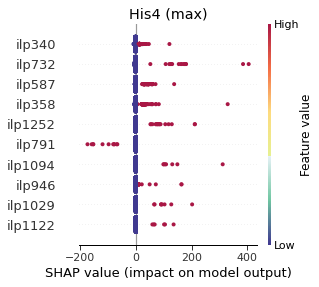

<Figure size 432x288 with 0 Axes>

In [36]:
# Visualize the shap-values
# P07342
fig = plt.figure(figsize = (10,6))
plt.subplot(2, 2, 1)
plt.title('Ilv2 (mean)')
raw_shap_values, raw_data_values, df_feature_importance = extract_top_features('../results/feature_values/Detailed/'+Protein_2+'_SHAP.pickle', 'asd')
shap.summary_plot(raw_shap_values, features=raw_data_values, cmap = create_cmap(), 
                  feature_names = df_feature_importance.feature.values, plot_size = 0.6, color_bar = False, use_log_scale=False)

plt.subplot(2, 2, 2)
plt.title('Ilv2 (max)')
raw_shap_values, raw_data_values, df_feature_importance = extract_top_features('../results/feature_values/Detailed/'+Protein_2+'_SHAP.pickle', 'max')
shap.summary_plot(raw_shap_values, features=raw_data_values, cmap = create_cmap(), 
                  feature_names = df_feature_importance.feature.values, plot_size = 0.6, use_log_scale=False)

# P00815
plt.subplot(2, 2, 3)
plt.title('His4 (mean)')
raw_shap_values, raw_data_values, df_feature_importance = extract_top_features('../results/feature_values/Detailed/'+Protein_1+'_SHAP.pickle', 'asd')
shap.summary_plot(raw_shap_values, features=raw_data_values, cmap = create_cmap(), 
                  feature_names = df_feature_importance.feature.values, plot_size = 0.6, color_bar = False, use_log_scale=False)

plt.subplot(2, 2, 4)
plt.title('His4 (max)')
raw_shap_values, raw_data_values, df_feature_importance = extract_top_features('../results/feature_values/Detailed/'+Protein_1+'_SHAP.pickle', 'max')
shap.summary_plot(raw_shap_values, features=raw_data_values, cmap = create_cmap(), 
                  feature_names = df_feature_importance.feature.values, plot_size = 0.6, use_log_scale=False)
plt.tight_layout()